# Introduction to Natural Language Processing with fastText
In this notebook we will discuss what is Natural Language Processing (NLP) and how to easily implement several projects using the library [fastText](https://github.com/facebookresearch/fastText). fastText is implemented in C++, however, there is a python wrapper, [fastText.py](https://github.com/salestock/fastText.py), that we are going to use in this notebook.

In [40]:
#Load all libraries
import os,sys  
import pandas as pd
import numpy as np
import fasttext
try:
    # For Python 3.0 and later
    from urllib.request import urlopen
except ImportError:
    # Fall back to Python 2's urllib2
    from urllib2 import urlopen
try:
    from html import unescape  # python 3.4+
except ImportError:
    try:
        from html.parser import HTMLParser  # python 3.x (<3.4)
    except ImportError:
        from HTMLParser import HTMLParser  # python 2.x
    unescape = HTMLParser().unescape
from sklearn.manifold import TSNE
%pylab inline


print(sys.version)

Populating the interactive namespace from numpy and matplotlib
3.5.2 |Anaconda custom (64-bit)| (default, Jul  2 2016, 17:53:06) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


## Text classification
The first task will be to perform text classification dataset DBPedia, which can be accessed [here](https://drive.google.com/drive/folders/0Bz8a_Dbh9Qhbfll6bVpmNUtUcFdjYmF2SEpmZUZUcVNiMUw1TWN6RDV3a0JHT3kxLVhVR2M). The dataset consists of text descriptions of 14 different classes. The training set contains 560000 reviews and the test contains 70000. 

In [ ]:
#Load train set
train_file = 'dbpedia_train.csv'
df = pd.read_csv(train_file, header=None, names=['class','name','description'])

#Load test set
test_file = 'dbpedia_test.csv'
df_test = pd.read_csv(test_file, header=None, names=['class','name','description'])

#Mapping from class number to class name
class_dict={
1:'Company',
2:'EducationalInstitution',
3:'Artist',
4:'Athlete',
5:'OfficeHolder',
6:'MeanOfTransportation',
7:'Building',
8:'NaturalPlace',
9:'Village',
10:'Animal',
11:'Plant',
12:'Album',
13:'Film',
14:'WrittenWork'
}
df['class_name'] = df['class'].map(class_dict)
df.head()

In [ ]:
#df.describe().transpose()
desc = df.groupby('class')
desc.describe().transpose()

The next step is to treat the data. As of today, the python wrapper of fastText doesn't allow dataframes or iterators as inputs to their functions (however, they are [working on it](https://github.com/salestock/fastText.py/issues/78). We have to create an intermediate file. This intermediate file doesn't have commas, non-ascii characters and everything is lowercase. The changes are based on [this script](https://github.com/facebookresearch/fastText/blob/a88344f6de234bdefd003e9e55512eceedde3ec0/classification-example.sh#L17).

In [ ]:
def clean_dataset(dataframe, shuffle=False, encode_ascii=False, clean_strings = False, label_prefix='__label__'):
    # Transform train file
    df = dataframe[['name','description']].apply(lambda x: x.str.replace(',',' '))
    df['class'] = label_prefix + dataframe['class'].astype(str) + ' '
    if clean_strings:
        df[['name','description']] = df[['name','description']].apply(lambda x: x.str.replace('"',''))
        df[['name','description']] = df[['name','description']].apply(lambda x: x.str.replace('\'',' \' '))
        df[['name','description']] = df[['name','description']].apply(lambda x: x.str.replace('.',' . '))
        df[['name','description']] = df[['name','description']].apply(lambda x: x.str.replace('(',' ( '))
        df[['name','description']] = df[['name','description']].apply(lambda x: x.str.replace(')',' ) '))
        df[['name','description']] = df[['name','description']].apply(lambda x: x.str.replace('!',' ! '))
        df[['name','description']] = df[['name','description']].apply(lambda x: x.str.replace('?',' ? '))
        df[['name','description']] = df[['name','description']].apply(lambda x: x.str.replace(':',' '))
        df[['name','description']] = df[['name','description']].apply(lambda x: x.str.replace(';',' '))
        df[['name','description']] = df[['name','description']].apply(lambda x: x.str.lower())
    if shuffle:
        from sklearn.utils import shuffle
        df = shuffle(df).reset_index(drop=True)
        #df.sample(frac=1).reset_index(drop=True)
    if encode_ascii :
        df[['name','description']] = df[['name','description']].apply(lambda x: x.str.normalize('NFKD').str.encode('ascii','ignore').str.decode('utf-8'))
    df['name'] = ' ' + df['name'] + ' '
    df['description'] = ' ' + df['description'] + ' '
    return df

In [ ]:
%%time
# Transform datasets
df_train_clean = clean_dataset(df, True, False)
df_test_clean = clean_dataset(df_test, False, False)

# Write files to disk
train_file_clean = 'dbpedia.train'
df_train_clean.to_csv(train_file_clean, header=None, index=False, columns=['class','name','description'] )

test_file_clean = 'dbpedia.test'
df_test_clean.to_csv(test_file_clean, header=None, index=False, columns=['class','name','description'] )

Once the dataset is cleaned, the next step is to train the classifier. 

In [ ]:
%%time
# Train a classifier
output_file = 'dp_model'
classifier = fasttext.supervised(train_file_clean, output_file, label_prefix='__label__')

Once the model is trained, we can test its accuracy. We can obtain the [percision and recall](https://en.wikipedia.org/wiki/Precision_and_recall) of the model. High precision means that an algorithm returned substantially more relevant results than irrelevant ones, while high recall means that an algorithm returned most of the relevant results.

In [ ]:
%%time
# Evaluate classifier
result = classifier.test(test_file_clean)
print('P@1:', result.precision)
print('R@1:', result.recall)
print ('Number of examples:', result.nexamples)

The next step is to check how the model works with real sentences.

In [ ]:
sentence1 = ['Picasso was a famous painter born in Malaga, Spain. He revolutionized the art in the 20th century.']
labels1 = classifier.predict(sentence1)
class1 = int(labels1[0][0])
print("Sentence: ", sentence1[0])
print("Label: %d; label name: %s" %(class1, class_dict[class1]))

sentence2 = ['One of my favourite tennis players in the world is Rafa Nadal.']
labels2 = classifier.predict_proba(sentence2)
class2, prob2 = labels2[0][0] # it returns class2 as string
print("Sentence: ", sentence2[0])
print("Label: %s; label name: %s; certainty: %f" %(class2, class_dict[int(class2)], prob2))

sentence3 = ['Say what one more time, I dare you, I double-dare you motherfucker!']
number_responses = 3
labels3 = classifier.predict_proba(sentence3, k=number_responses)
print("Sentence: ", sentence3[0])
for l in range(number_responses):
    class3, prob3 = labels3[0][l]
    print("Label: %s; label name: %s; certainty: %f" %(class3, class_dict[int(class3)], prob3))


The model predicts sentence 1 as `Artist`, which is correct. Sentence 2 is also predicted correctly. This time we used the function `predict_proba` that retruns the certainty of the prediction as a probability. Finally, sentence 3 was not correctly classified. The correct label would be `Film`, since the sentence is from famous scene of a very good film. If by any chance, you don't know [what I'm talking about](https://www.youtube.com/watch?v=xwT60UbOZnI), well, please put your priorities in order. Stop reading this notebook, go to see Pulp Fiction, and then come back to keep learning NLP :-)

## Sentiment Analysis
Sentiment analysis is one of the most important use cases in text classification. The objective is to classify a piece of text into positive, negative and, in some cases, neutral. This is extensively used by brands to understand the perception their customers. Sentiment analysis can influence marketing campaigns, generate leads, plan product development or improeve customer service.  

In our notebook, we will use the Amazon polarity dataset, which contains 3.6 million reviews in the train set and 400.000 reviews in the test set. The reviews are positive, 1, or negative, 2. The dataset can be found [here](https://drive.google.com/drive/folders/0Bz8a_Dbh9Qhbfll6bVpmNUtUcFdjYmF2SEpmZUZUcVNiMUw1TWN6RDV3a0JHT3kxLVhVR2M). 

The first step is to prepare the dataset for the algorithm format.

In [ ]:
%%time
#Load train set
train_file = 'amazon_review_polarity_train.csv'
df_sentiment_train = pd.read_csv(train_file, header=None, names=['class','name','description'])

#Load test set
test_file = 'amazon_review_polarity_test.csv'
df_sentiment_test = pd.read_csv(test_file, header=None, names=['class','name','description'])

# Transform datasets
df_train_clean = clean_dataset(df_sentiment_train, True, False)
df_test_clean = clean_dataset(df_sentiment_test, False, False)

# Write files to disk
train_file_clean = 'amazon.train'
df_train_clean.to_csv(train_file_clean, header=None, index=False, columns=['class','name','description'] )

test_file_clean = 'amazon.test'
df_test_clean.to_csv(test_file_clean, header=None, index=False, columns=['class','name','description'] )

Once we have the data, let's train the classifier. This time instead of the default parameters we are going to use those used in the [fastText paper](https://arxiv.org/abs/1607.01759).

In [ ]:
%%time
# Parameters
dim=10
lr=0.1
epoch=5
min_count=1
word_ngrams=2
bucket=10000000
thread=12
label_prefix='__label__'

# Train a classifier
output_file = 'amazon_model'
classifier = fasttext.supervised(train_file_clean, output_file, dim=dim, lr=lr, epoch=epoch,
                                 min_count=min_count, word_ngrams=word_ngrams, bucket=bucket,
                                 thread=thread, label_prefix=label_prefix)

Now let's evaluate the results

In [ ]:
%%time
# Evaluate classifier
result = classifier.test(test_file_clean)
print('P@1:', result.precision)
print('R@1:', result.recall)
print ('Number of examples:', result.nexamples)

Finally, let's evaluate some sentences

In [ ]:
class_dict={
    1:"Negative",
    2:"Positive"
}

sentence1 = ["The product design is nice but it's working as expected"]
labels1 = classifier.predict_proba(sentence1)
class1, prob1 = labels1[0][0] # it returns class as string
print("Sentence: ", sentence1[0])
print("Label: %s; label name: %s; certainty: %f" %(class1, class_dict[int(class1)], prob1))

sentence2 = ["I bought the product a month ago and it was working correctly. But now is not working great"]
labels2 = classifier.predict_proba(sentence2)
class2, prob2 = labels2[0][0] # it returns class as string
print("Sentence: ", sentence2[0])
print("Label: %s; label name: %s; certainty: %f" %(class2, class_dict[int(class2)], prob2))

We can use a tweet as the text input. Twitter has a [REST API](https://dev.twitter.com/rest/public) that allows you to interact with all their data. However, everything from that API requires authentication (an example can be found in this [Twitter bot](https://github.com/miguelgfierro/twitter_bot) I made). Instead, we can parse the title of the tweet url, which contains the text of the tweet.

In [ ]:
# Get twitter data
url = "https://twitter.com/miguelgfierro/status/805827479139192832"
response = urlopen(url).read()
title = str(response).split('<title>')[1].split('</title>')[0]
print(title)

# Format tweet
tweet = unescape(title)
print(tweet)

# Classify tweet
label_tweet = classifier.predict_proba([tweet])
class_tweet, prob_tweet = label_tweet[0][0]
print("Label: %s; label name: %s; certainty: %f" %(class_tweet, class_dict[int(class_tweet)], prob_tweet))

## Word representations
We can also use fastText to lean word vectors. This is way to represent words in a multidimemsional spaces, where each word has a coordinate. Similar words will be clustered in a specific region of this multidimensional space. 

As an example we are going to download the English Wikipedia 9 dataset: [enwik9](http://mattmahoney.net/dc/enwik9.zip). The data is UTF-8 encoded XML consisting primarily of English text. enwik9 contains 243,426 article titles, of which 85,560 are #REDIRECT to fix broken links, and the rest are regular articles.  

We can use the script `wikifil.pl` by [Matt Mahoney](http://mattmahoney.net/dc/textdata.html) to clean the data. Thi script filter Wikipedia XML dumps to "clean" text consisting only of lowercase letters (a-z, converted from A-Z), and spaces (never consecutive).  All other characters are converted to spaces.  Only text which normally appears in the web browser is displayed.  Tables are removed.  Image captions are preserved.  Links are converted to normal text.  Digits are spelled out. 

In [ ]:
wiki_dataset_original = 'enwik9'
wiki_dataset = 'text9'
if not os.path.isfile(wiki_dataset):
    os.system("perl wikifil.pl " +  wiki_dataset_original + " > " + wiki_dataset)

Let's compute the Skipgram model of the dataset. We will obtain a for each word of 50 dimensions. 

In [2]:
%%time
# Learn the word representation using skipgram model
output_skipgram = 'skipgram'
if os.path.isfile(output_skipgram + '.bin'):
    skipgram = fasttext.load_model(output_skipgram + '.bin')
else:
    skipgram = fasttext.skipgram(wiki_dataset, output_skipgram, lr=0.02, dim=50, ws=5,
        epoch=1, min_count=5, neg=5, loss='ns', bucket=2000000, minn=3, maxn=6,
        thread=4, t=1e-4, lr_update_rate=100)
print(np.asarray(skipgram['king']))

[-0.19035423  0.12919889 -0.01621816  0.91914248 -0.04784911  1.01419783
 -0.92824554  0.11770941 -1.27806365  0.56500137  0.12494227  0.06474512
 -0.08386051 -0.31484714 -1.50665426 -0.16161649 -0.26169592  0.21585882
 -0.63624233 -0.06576108  0.50950927  0.5873729   0.05553412 -0.02354425
  0.17441362  0.04380872 -0.10647007 -0.01144043 -0.75747365  0.0809597
 -0.01709513 -0.5643698   0.69850397 -0.11577342 -0.43974972 -0.13017809
  0.85398453 -0.44535291  0.0892249   0.37722048 -0.65688199  0.02948143
  0.1659707  -0.63430309 -0.89483672 -0.51257765 -0.04378932  0.25176015
  0.48368916 -0.75240171]
CPU times: user 760 ms, sys: 292 ms, total: 1.05 s
Wall time: 32.7 s


Since each word is represented in a multidimensional space, we can compute the similarity between words. The difference between king and queen will be smaller than between king and woman. Make sense right. At the same time the difference between man and woman will be smaller than king and woman. 

With word representations we are able to map from words to numerical values. What we are doing in fact is to featurize the words. The feautures can be used in different algorithms to learn the meaning of a text.

In [ ]:
print("Number of words in the model: ", len(skipgram.words))

# Get the vector of some word
Droyals = np.sqrt(pow(np.asarray(skipgram['king']) - np.asarray(skipgram['queen']), 2)).sum()
print(Droyals)
Dpeople = np.sqrt(pow(np.asarray(skipgram['king']) - np.asarray(skipgram['woman']), 2)).sum()
print(Dpeople)
Dpeople2 = np.sqrt(pow(np.asarray(skipgram['man']) - np.asarray(skipgram['woman']), 2)).sum()
print(Dpeople2)

## Word space visualization

Once we have the vectorial word representation, where each word is in a 50 dimensional space, it would be great if we could visualize the words in a reduced space.

For that we will use t-Distributed Stochastic Neighbor Embedding (t-SNE) from [van der Mateen and Hinton (2008)](http://jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf). t-SNE is a dimensionality reduction method that is particularly well suited for the visualization of high-dimensional datasets. The idea is to compute the probability distribution of pairs of high dimensional objects in such a way that similar objects have high probability of being clustered together and disimilar objects have low probability of being clustered together. Afterwards, the algorithm maps these probabilities in the low dimensional space and optimizes the distance with respect to the object's location in that space. Therefore, at the end of the optimization, similar objects are close in the low dimensional space. 

First, we are going to define the words that we going to analyze out of the complete corpus that contains more than 200.000 objects. We have chosen 10 words related to people and 10 words related to animals. 

Once we select the words to analize we are going to get the word vectors of these words.

In [72]:
print(len(skipgram.words))
targets = ['man','woman','king','queen','brother','sister','father','mother','grandfather','grandmother',
           'cat','dog','bird','squirrel','horse','pig','dove','wolf','kitten','puppy']
classes = [1,1,1,1,1,1,1,1,1,1,
           2,2,2,2,2,2,2,2,2,2]

218316


In [65]:
X_target=[]
for w in targets:
    X_target.append(skipgram[w])
X_target = np.asarray(X_target)

Next step is to select a subset of the dataset because computing more than 200.000 objects is too expensive.

In [66]:
word_list = list(skipgram.words)[:10000]
X_subset=[]
for w in word_list:
    X_subset.append(skipgram[w])
X_subset = np.asarray(X_subset)

We add both datasets together.

In [67]:
X_target = np.concatenate((X_subset, X_target))
print(X_target.shape)

(10020, 50)


Next, we compute the t-SNE algorithm.

In [69]:
%%time
X_tsne = TSNE(n_components=2, perplexity=40, init='pca', method='exact',
                  random_state=0, n_iter=200, verbose=2).fit_transform(X_target)
print(X_tsne.shape)

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 10020
[t-SNE] Computed conditional probabilities for sample 2000 / 10020
[t-SNE] Computed conditional probabilities for sample 3000 / 10020
[t-SNE] Computed conditional probabilities for sample 4000 / 10020
[t-SNE] Computed conditional probabilities for sample 5000 / 10020
[t-SNE] Computed conditional probabilities for sample 6000 / 10020
[t-SNE] Computed conditional probabilities for sample 7000 / 10020
[t-SNE] Computed conditional probabilities for sample 8000 / 10020
[t-SNE] Computed conditional probabilities for sample 9000 / 10020
[t-SNE] Computed conditional probabilities for sample 10000 / 10020
[t-SNE] Computed conditional probabilities for sample 10020 / 10020
[t-SNE] Mean sigma: 0.478106
[t-SNE] Iteration 25: error = 23.2986598, gradient norm = 0.0508359
[t-SNE] Iteration 50: error = 23.6358435, gradient norm = 0.0495398
[t-SNE] Iteration 75: error = 22.8933413, gradient norm 

If we plot all the words it was impossible to understand anything, so we are only going to represent the target words.

In [70]:
X_tsne_target = X_tsne[-20:,:]
print(X_tsne_target.shape)

(20, 2)


In [ ]:
def plot_words(X, labels, classes=None, xlimits=None, ylimits=None):
    fig = figure(figsize=(6, 6))
    if xlimits is not None:
        xlim(xlimits)
    if ylimits is not None:
        ylim(ylimits)
    scatter(X[:, 0], X[:, 1], c=classes)
    for i, txt in enumerate(labels):
        annotate(txt, (X[i, 0], X[i, 1]))

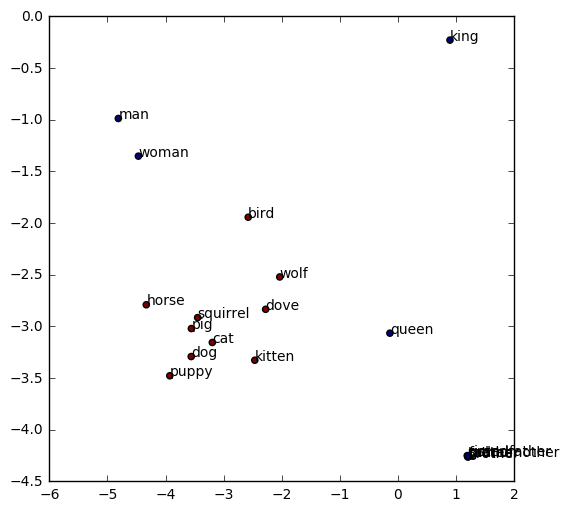

In [71]:
plot_words(X_tsne_target, targets, classes=classes)

In the previous plot we can see the target words represented in a 2 dimensional space. As you can see, words related to animals are clustered together. The words related to people form a couple of clusters. We can take a zoom to the cluster to the bottom left to see what words are clustered together

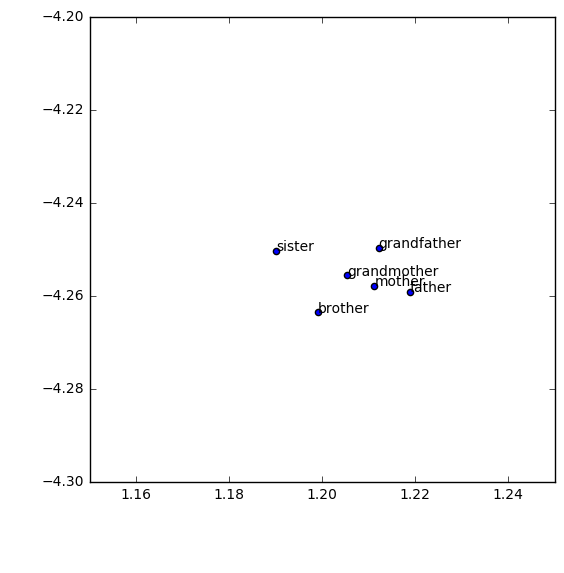

In [73]:
plot_words(X_tsne_target, targets, xlimits=[1.15,1.25], ylimits=[-4.3,-4.2])

## Conclusion 
In this notebook we have shown how to classify text, perform sentiment analysis, create word representations and visualize these representations in a XY plot. fastText is a easy to use framework to work these NLP problems. Its most remarkable feature is its computation speed, that allows to train models very quick mantaining a high level of accuracy in comparison with other areas like [deep learning](https://arxiv.org/abs/1509.01626). 